In [158]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


The CERES Team has made considerable efforts to remove major errors and to verify the quality and accuracy of this data. Please specify the CERES product and version as "CERES EBAF Ed4.1" and provide a reference to the following paper when you publish scientific results with the data:

Loeb, N.G., D.R. Doelling, H. Wang, W. Su, C. Nguyen, J.G. Corbett, L. Liang, C. Mitrescu, F.G. Rose, and S. Kato, 2018: Clouds and the Earth's Radiant Energy System (CERES) Energy Balanced and Filled (EBAF) Top-of-Atmosphere (TOA) Edition-4.0 Data Product. Journal of Climate, Volume 31, Issue 2 (January 2018) pp. 895-918. doi: 10.1175/JCLI-D-17-0208.1
Kato, S., F. G. Rose, D. A. Rutan, T. E. Thorsen, N. G. Loeb, D. R. Doelling, X. Huang, W. L. Smith, W. Su, and S.-H. Ham, 2018: Surface irradiances of Edition 4.0 Clouds and the Earth's Radiant Energy System (CERES) Energy Balanced and Filled (EBAF) data product, Journal of Climate, Volume 31, 4501-4527, doi:10.1175/JCLI-D-17-0523.1

In [160]:
ds_obs = xr.open_dataset('../CERES_EBAF_Ed4.1_Subset_200003-202011.nc')
month_ds_dict = {} 
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
run_name = 'low7_albedo' #if looking at the sensitivity to 500m scale factor for turbulence: '500_m_scale'

for month in months: 
    month_ds_dict[month] = xr.open_dataset(f'../output/{month}_{run_name}_ds')

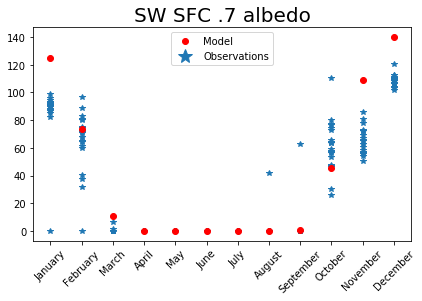

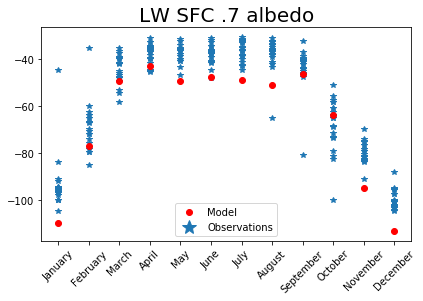

In [161]:
#surface SW
fig, ax = plt.subplots()
for year in np.arange(2000,2020):
    plt.plot(ds_obs['sfc_net_sw_clr_t_mon'].sel(lat = -89.5, lon = 0.5).sel(time=ds_obs.time.dt.year.isin([year])), 'C0*', label = 'Observations')
for idx, month in enumerate(months):
    plt.plot(month, month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = -1)['SW_flux_net_clr'], 'ro', label = 'Model')
plt.xticks(rotation = 45)
hand, labl = ax.get_legend_handles_labels()
plt.legend(np.unique(labl))
plt.tight_layout()
plt.title('SW SFC .7 albedo', fontsize = 20)
legend_elements = [Line2D([0], [0], marker = 'o', linestyle = None, color='r', lw=0, label='Model'),
                   Line2D([0], [0], marker='*',  linestyle = None, color='C0', lw=0, label='Observations',
                          markerfacecolor='C0', markersize=15)]
# Create the figure
plt.legend(handles=legend_elements, loc='best')

#surface LW
fig, ax = plt.subplots()
for year in np.arange(2000,2020):
    plt.plot(ds_obs['sfc_net_lw_clr_t_mon'].sel(lat = -89.5, lon = 0.5).sel(time=ds_obs.time.dt.year.isin([year])), 'C0*', label = 'Observations')
for idx, month in enumerate(months):
    plt.plot(month, -month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = -1)['LW_flux_net_clr'], 'ro', label = 'Model') #have to make negative because of the difference in output of sign
plt.xticks(rotation = 45)
hand, labl = ax.get_legend_handles_labels()
plt.legend(np.unique(labl))
plt.tight_layout()
plt.title('LW SFC .7 albedo', fontsize = 20)
legend_elements = [Line2D([0], [0], marker = 'o', linestyle = None, color='r', lw=0, label='Model'),
                   Line2D([0], [0], marker='*',  linestyle = None, color='C0', lw=0, label='Observations',
                          markerfacecolor='C0', markersize=15)]
# Create the figure
plt.legend(handles=legend_elements, loc='best')


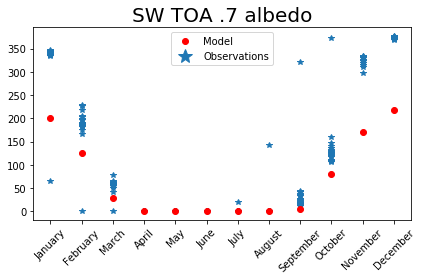

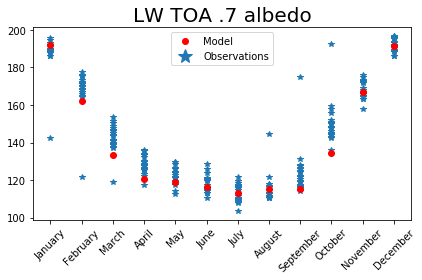

In [162]:
fig, ax = plt.subplots()
for year in np.arange(2000,2020):
    plt.plot(ds_obs['toa_sw_clr_t_mon'].sel(lat = -89.5, lon = 0.5).sel(time=ds_obs.time.dt.year.isin([year])), 'C0*', label = 'Observations')
for idx, month in enumerate(months):
    plt.plot(month, month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['SW_flux_net_clr'], 'ro', label = 'Model')
plt.xticks(rotation = 45)
plt.title('SW TOA .7 albedo', fontsize = 20)
hand, labl = ax.get_legend_handles_labels()
plt.legend(np.unique(labl))
plt.tight_layout()
legend_elements = [Line2D([0], [0], marker = 'o', linestyle = None, color='r', lw=0, label='Model'),
                   Line2D([0], [0], marker='*',  linestyle = None, color='C0', lw=0, label='Observations',
                          markerfacecolor='C0', markersize=15)]
# Create the figure
plt.legend(handles=legend_elements, loc='best')

fig, ax = plt.subplots()
for year in np.arange(2000,2020):
    plt.plot(ds_obs['toa_lw_clr_t_mon'].sel(lat = -89.5, lon = 0.5).sel(time=ds_obs.time.dt.year.isin([year])), 'C0*', label = 'Observations')
for idx, month in enumerate(months):
    plt.plot(month, month_ds_dict[month].sel(time = 0, model = 'rat', co2_lev = 0).isel(lev_bounds = 0)['LW_flux_net_clr'], 'ro', label = 'Model')
plt.xticks(rotation = 45)
plt.title('LW TOA .7 albedo', fontsize = 20);
hand, labl = ax.get_legend_handles_labels()
plt.legend(np.unique(labl))
plt.tight_layout()
legend_elements = [Line2D([0], [0], marker = 'o', linestyle = None, color='r', lw=0, label='Model'),
                   Line2D([0], [0], marker='*',  linestyle = None, color='C0', lw=0, label='Observations',
                          markerfacecolor='C0', markersize=15)]
# Create the figure
plt.legend(handles=legend_elements, loc='best')